# Notebook 010: Boston Property Assessments EDA and feature enrichment

This notebooks contains preliminary EDA for Boston property assessments, fiscal years 2013-2019.

Activities completed in this notebook include:

1. Merge all fiscal year records into a single datafile/dataframe
2. Match corresponding latitude and longitude coordinates to each property assessment record
3. Identify missingness of geo-location coordinates (i.e. unmatched remaining assessments)
4. Perform EDA on the dataset
5. Enrich the dataset with additional features (e.g. census-tract indicators, multi-year change rates, etc.)
6. Generate new summary datasets ultimately used for generating engineered features in our final predictive analysis

In [1]:
import urllib
import os
import pathlib
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [151]:
DATA_ROOT = '../data/'
READDIR_ROOT = os.path.join(DATA_ROOT, 'raw')
WRITEDIR_ROOT = os.path.join(DATA_ROOT, 'interim')
readfile_prop_dir = os.path.join(READDIR_ROOT, 'property')
readfile_sam = os.path.join(READDIR_ROOT, 'boston/sam-addresses.csv')
readfile_zipshapes = os.path.join(READDIR_ROOT, 'shapefile/zipcodes/ZIP_Codes.shp')
readfile_cityshape = os.path.join(READDIR_ROOT, 'shapefile/city-boundary/City_of_Boston_Boundary.shp')
readfile_streetshapes = os.path.join(READDIR_ROOT, 'shapefile/street-segments/Boston_Street_Segments.shp')

print(
    'readfile paths for datasets used in this notebook are:\n\t{}\n\t{}\n\t{}'.format(
        readfile_prop_dir, readfile_sam, readfile_zipshapes
    )
)

readfile paths for datasets used in this notebook are:
	../data/raw/property
	../data/raw/boston/sam-addresses.csv
	../data/raw/shapefile/zipcodes/ZIP_Codes.shp


In [155]:
# read in SAM address data and related shapefiles
df_sam = pd.read_csv(readfile_sam, dtype=str)
gdf_zips = gpd.read_file(readfile_zipshapes)
gdf_boston = gpd.read_file(readfile_cityshape)
gdf_streets = gpd.read_file(readfile_streetshapes)

# convert SAM data lat/lon values to floats
df_sam[['X', 'Y']] = df_sam[['X', 'Y']].astype(float)

In [84]:
# check info of SAM dataframe
df_sam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398693 entries, 0 to 398692
Data columns (total 27 columns):
X                       398693 non-null float64
Y                       398693 non-null float64
SAM_ADDRESS_ID          398693 non-null object
RELATIONSHIP_TYPE       398693 non-null object
BUILDING_ID             398693 non-null object
FULL_ADDRESS            398693 non-null object
STREET_NUMBER           398693 non-null object
IS_RANGE                398693 non-null object
RANGE_FROM              26176 non-null object
RANGE_TO                26176 non-null object
UNIT                    270097 non-null object
FULL_STREET_NAME        398693 non-null object
STREET_ID               398693 non-null object
STREET_PREFIX           398693 non-null object
STREET_BODY             398693 non-null object
STREET_SUFFIX_ABBR      394515 non-null object
STREET_FULL_SUFFIX      394515 non-null object
STREET_SUFFIX_DIR       398693 non-null object
STREET_NUMBER_SORT      398693 non-null obj

In [20]:
%%time
#####################################################################
## READ IN ALL PROPERTY ASSESSMENT FILES TO DICT OF DATAFRAME OBJECTS
#####################################################################

# read all property assessment datafiles into dictionary
property_file_list = os.listdir(readfile_prop_dir)
prop_df_dict = {
    '20{0}'.format(filename[2:4]): pd.read_csv(
        os.path.join(readfile_prop_dir, filename),
        dtype=str
    )
    for filename in property_file_list
}
prop_df_dict_keys = sorted(list(prop_df_dict.keys()))

CPU times: user 8.67 s, sys: 312 ms, total: 8.99 s
Wall time: 8.98 s


In [21]:
# inspect df shapes and columns
print('fiscal year\tdataframe shape\n')

for key in prop_df_dict_keys:
    print('{0}\t\t{1}'.format(key, prop_df_dict[key].shape))

fiscal year	dataframe shape

2013		(165608, 54)
2014		(164091, 56)
2015		(168115, 56)
2016		(169199, 77)
2017		(170910, 75)
2018		(172841, 75)
2019		(174668, 75)


In [31]:
# check for differences among dataframe columns year over year
# these will need to be standardized before concatenating dfs
prop_df_columns_dict = {
    year: list(dataframe.columns)
    for year, dataframe in prop_df_dict.items() 
}

column_changes_by_year = {
    year: [
        list(set(prop_df_columns_dict[str(int(year)-1)]).difference(set(prop_df_columns_dict[year]))),
        list(set(prop_df_columns_dict[year]).difference(set(prop_df_columns_dict[str(int(year)-1)])))
    ] for year in prop_df_dict_keys[1:]
}

print('Changes in dataframe column names by fiscal year assessment report:\n')
for key in column_changes_by_year.keys():
    print(key)
    print('  prior year columns removed:\n   {0}'.format(column_changes_by_year[key][0]))
    print('  current year columns added:\n   {0}'.format(column_changes_by_year[key][1]))
    print()

Changes in dataframe column names by fiscal year assessment report:

2014
  prior year columns removed:
   ['MAIL_ZIPCODE', 'MAIL_ADDRESS', 'MAIL CS', 'U_NUM_PARK', 'PID']
  current year columns added:
   ['Unnamed: 55', 'Owner_MAIL_ZIPCODE', 'Location', 'Owner_MAIL_CS', 'Parcel_ID', 'full_address', 'Owner_MAIL_ADDRESS']

2015
  prior year columns removed:
   ['Unnamed: 55', 'Owner_MAIL_ZIPCODE', 'Owner_MAIL_CS', 'Parcel_ID', 'Owner_MAIL_ADDRESS']
  current year columns added:
   ['U_NUM_PARK', 'PID', 'OWNER_MAIL_ZIPCODE', 'OWNER_MAIL_ADDRESS', 'OWNER_MAIL_CS']

2016
  prior year columns removed:
   ['Location', 'OWNER_MAIL_ZIPCODE', 'full_address', 'OWNER_MAIL_ADDRESS', 'OWNER_MAIL_CS', 'U_KIT_TYPE']
  current year columns added:
   ['R_VIEW', 'R_INT_CND', 'R_BTH_STYLE3', 'U_KITCH_STYLE', 'U_BTH_STYLE3', 'MAIL_ADDRESS', 'S_EXT_CND', 'R_KITCH_STYLE', 'U_BTH_STYLE', 'R_EXT_CND', 'R_KITCH_STYLE3', 'LONGITUDE', 'U_KITCH_TYPE', 'MAIL_ZIPCODE', 'R_INT_FIN', 'MAIL CS', 'R_BTH_STYLE', 'R_BTH_

In [56]:
# list of columns to add to dataframes for years in which they are missing
add_columns_list = [
    'LATITUDE', 'LONGITUDE', 
    'Location', 'full_address',
    'MAIL_ADDRESSEE', 'GIS_ID',
    'U_NUM_PARK', 'R_VIEW', 'R_INT_CND',
    'R_BTH_STYLE3', 'U_KITCH_STYLE',
    'U_BTH_STYLE3', 'S_EXT_CND',
    'R_KITCH_STYLE', 'U_BTH_STYLE',
    'R_EXT_CND', 'R_KITCH_STYLE3',
    'R_INT_FIN', 'R_BTH_STYLE',
    'R_BTH_STYLE2', 'R_OVRALL_CND',
    'R_KITCH_STYLE2', 'U_INT_CND',
    'U_VIEW',  'U_INT_FIN', 'U_BTH_STYLE2'
]

# mapping dict to rename column names with variations in spelling
rename_columns_dict = {
    'Parcel_ID': 'PID',
    'OWNER_MAIL_ZIPCODE': 'MAIL_ZIPCODE',
    'Owner_MAIL_ZIPCODE': 'MAIL_ZIPCODE',
    'OWNER_MAIL_ADDRESS': 'MAIL_ADDRESS',
    'Owner_MAIL_ADDRESS': 'MAIL_ADDRESS',
    'OWNER_MAIL_CS': 'MAIL CS',
    'Owner_MAIL_CS': 'MAIL CS',
    'U_KIT_TYPE': 'U_KITCH_TYPE',
}

# list of columns to drop if they exist in df
drop_columns = ['Unnamed: 55']

In [58]:
############################################################
## MODIFY DATAFRAME COLUMNS TO MATCH FOR ALL FISCAL YEAR DFS
############################################################

# add fiscal year row values to each dataframe
for year in prop_df_dict_keys:
    prop_df_dict[year]['fiscal-year'] = year

# add columns to dataframes where they are missing
for year in prop_df_dict_keys:
    for column in add_columns_list:
        if column not in prop_df_dict[year]:
            prop_df_dict[year][column] = np.nan

# remap column names in dataframes where there are variations in naming
for year in prop_df_dict_keys:
    prop_df_dict[year] = prop_df_dict[year].rename(columns=rename_columns_dict)
    
# drop bad columns in drop_columns list if they exist
for year in prop_df_dict_keys:
    prop_df_dict[year] = prop_df_dict[year].drop(columns=drop_columns, errors='ignore')

In [59]:
# check results for matching df widths
print('fiscal year\tdataframe shape\n')

for key in prop_df_dict_keys:
    print('{0}\t\t{1}'.format(key, prop_df_dict[key].shape))

fiscal year	dataframe shape

2013		(165608, 80)
2014		(164091, 80)
2015		(168115, 80)
2016		(169199, 80)
2017		(170910, 80)
2018		(172841, 80)
2019		(174668, 80)


In [62]:
# check year by year column diffs again to ensure not diffs for any years
prop_df_columns_dict_check = {
    year: list(dataframe.columns)
    for year, dataframe in prop_df_dict.items() 
}

column_changes_by_year_check = {
    year: [
        list(set(prop_df_columns_dict_check[str(int(year)-1)]).difference(set(prop_df_columns_dict_check[year]))),
        list(set(prop_df_columns_dict_check[year]).difference(set(prop_df_columns_dict_check[str(int(year)-1)])))
    ] for year in prop_df_dict_keys[1:]
}

print('Changes in dataframe column names by fiscal year assessment report:\n')
for key in column_changes_by_year_check.keys():
    print(key)
    print('  prior year columns removed:\n   {0}'.format(column_changes_by_year_check[key][0]))
    print('  current year columns added:\n   {0}'.format(column_changes_by_year_check[key][1]))
    print()

Changes in dataframe column names by fiscal year assessment report:

2014
  prior year columns removed:
   []
  current year columns added:
   []

2015
  prior year columns removed:
   []
  current year columns added:
   []

2016
  prior year columns removed:
   []
  current year columns added:
   []

2017
  prior year columns removed:
   []
  current year columns added:
   []

2018
  prior year columns removed:
   []
  current year columns added:
   []

2019
  prior year columns removed:
   []
  current year columns added:
   []



In [109]:
########################################################
## CONCATENATE ALL FISCAL YEAR DATAFRAMES INTO SINGLE DF 
########################################################

# The most recent fiscal year is used as the starting reference frame
prop_df = pd.concat(
    [prop_df_dict[year] for year in prop_df_dict_keys[::-1]],
    sort=False,
    ignore_index=True
)

In [110]:
# inspect resulting consolidated dataframe
print(prop_df.info())
prop_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185432 entries, 0 to 1185431
Data columns (total 80 columns):
PID                1185432 non-null object
CM_ID              528555 non-null object
GIS_ID             687305 non-null object
ST_NUM             1185432 non-null object
ST_NAME            1185432 non-null object
ST_NAME_SUF        1182792 non-null object
UNIT_NUM           438126 non-null object
ZIPCODE            1185407 non-null object
PTYPE              1185426 non-null object
LU                 1185431 non-null object
OWN_OCC            1185388 non-null object
OWNER              1185432 non-null object
MAIL_ADDRESSEE     610517 non-null object
MAIL_ADDRESS       1185432 non-null object
MAIL CS            1185432 non-null object
MAIL_ZIPCODE       1185430 non-null object
AV_LAND            1185430 non-null object
AV_BLDG            1185432 non-null object
AV_TOTAL           1185432 non-null object
GROSS_TAX          1185432 non-null object
LAND_SF            1161487 non-

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,...,U_AC,U_FPLACE,U_INT_FIN,U_INT_CND,U_VIEW,fiscal-year,LATITUDE,LONGITUDE,Location,full_address
0,0502550008,502550000,502550000,87,BEACON,ST,2-F,2108,102,CD,...,N,1,N,G,A,2019,NaN,NaN,NaN,NaN
1,0502550010,502550000,502550000,87,BEACON,ST,2-R,2108,102,CD,...,N,1,N,A,A,2019,NaN,NaN,NaN,NaN
2,0502550012,502550000,502550000,87,BEACON,ST,3-F,2108,102,CD,...,N,1,N,A,G,2019,NaN,NaN,NaN,NaN
3,0502550014,502550000,502550000,87,BEACON,ST,3-R,2108,102,CD,...,N,1,S,A,G,2019,NaN,NaN,NaN,NaN
4,0502550016,502550000,502550000,87,BEACON,ST,4,2108,102,CD,...,C,2,N,E,G,2019,NaN,NaN,NaN,NaN


In [134]:
# unpack 'Location' column coordinates to lat/lon columns and fill blanks
prop_df['LATITUDE'] = prop_df['LATITUDE'].fillna(
    prop_df['Location'].copy().str.split('(').str.get(1).str.split('|').str.get(0)
)
prop_df['LONGITUDE'] = prop_df['LONGITUDE'].fillna(
    prop_df['Location'].copy().str.split('|').str.get(1).str.split(')').str.get(0)
)

In [95]:
# check PID values to see unwanted characters
prop_df['PID'].value_counts().sort_index()[:6]

0100001000     3
0100001000_    4
0100002000     3
0100002000_    4
0100003000     3
0100003000_    4
Name: PID, dtype: int64

In [175]:
# remove all non-numeric characters from PID values
prop_df['PID'] = prop_df['PID'].str.replace(r'[^0-9]', '')

# generate a match key for all PIDs with available lats/lons
PID_coord_match_key = prop_df.groupby('PID').agg(
    {
        'LATITUDE': 'first',
        'LONGITUDE': 'first'
    }
)

# convert lat/lon from string to floats
PID_coord_match_key = PID_coord_match_key.astype(float)

# drop zero values
PID_coord_match_key = PID_coord_match_key.replace(0, np.nan)

# store match rate
PID_matchrate = sum(PID_coord_match_key['LATITUDE'].isnull()) / len(PID_coord_match_key) * 100

# print results to determine how many PIDs still need lat/lon matching
print(
    'Of the {0:,} unique PIDs contained in the {1:,} row consolidated '\
    'property assessment, the following number of PIDs have NO associated '\
    'lat/long coordinates:\n\n\t{2:,}\t{3:.2f}%'.format(
        len(PID_coord_match_key),
        len(prop_df),
        sum(PID_coord_match_key['LATITUDE'].isnull()),
        PID_matchrate
    )
)

Of the 174,167 unique PIDs contained in the 1,185,432 row consolidated property assessment, the following number of PIDs have NO associated lat/long coordinates:

	17,541	10.07%


In [171]:
PID_coord_match_key.describe()

,LATITUDE,LONGITUDE
count,156626.000000,156626.000000
mean,42.322702,-71.090414
std,0.035381,0.038854
min,42.231084,-71.184852
25%,42.290830,-71.120882
50%,42.330811,-71.080520
75%,42.350373,-71.061847
max,42.396151,-70.927573


In [172]:
df_sam[['X', 'Y']].describe()

,X,Y
count,398693.000000,398693.000000
mean,-71.087995,42.326483
std,0.036683,0.033457
min,-71.185400,42.230249
25%,-71.114091,42.299679
50%,-71.080711,42.335059
75%,-71.061481,42.350859
max,-70.989053,42.395182


In [170]:
PID_coord_match_key.sort_values(by='LONGITUDE').dropna()

,LATITUDE,LONGITUDE
PID,,
2008918000,42.288833,-71.184852
2008937000,42.287656,-71.184727
2008936000,42.288077,-71.184265
2008938000,42.286857,-71.184038
2008935000,42.288374,-71.183939
2008939000,42.287001,-71.183883
2008940000,42.287213,-71.183662
2008934000,42.288630,-71.183613
2008942000,42.287423,-71.183444


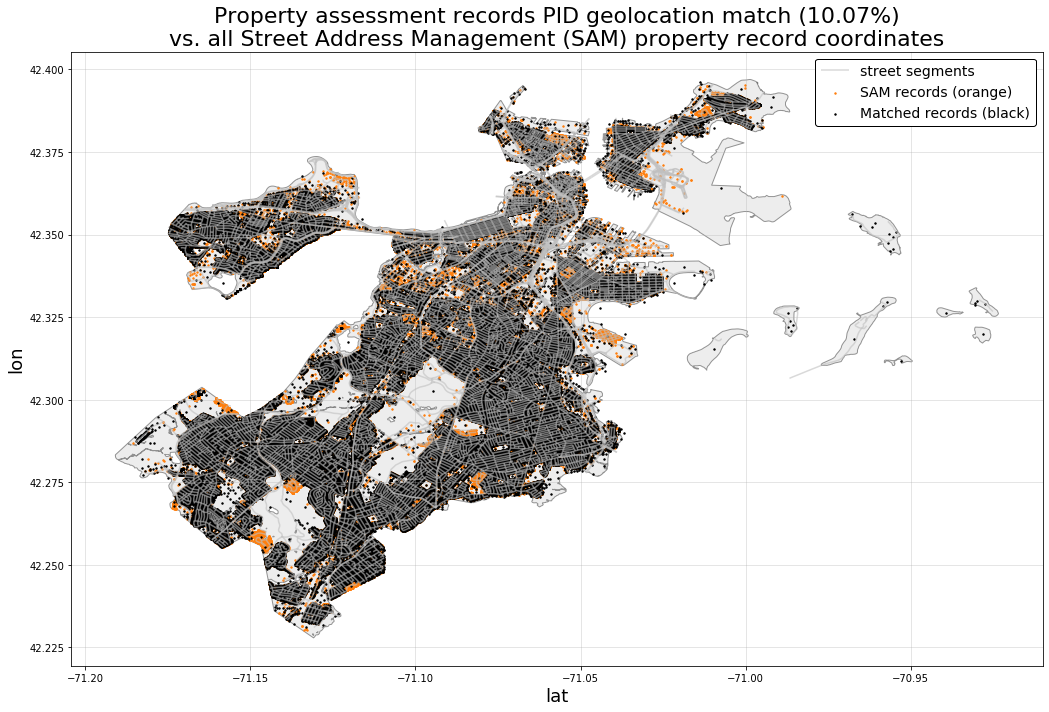

CPU times: user 5.67 s, sys: 75.8 ms, total: 5.75 s
Wall time: 5.75 s


In [178]:
%%time

# Plot PID coordinates from consolidated property dataset over top
# of SAM addresses master list to identify what areas are missing and
# potential sources of bias in our data

# plot unique SAM records with city boundary and street segments overlays 
fig, ax = plt.subplots(figsize=(16,10))
gdf_boston.plot(ax=ax, color='lightgray', edgecolor='k', alpha=0.4)
gdf_streets.plot(ax=ax, color='silver', edgecolor='k', alpha=.6, label='street segments')
plt.title(
    'Property assessment records PID geolocation match ({0:.2f}%)\n'\
    'vs. all Street Address Management (SAM) property record coordinates'\
    ''.format(PID_matchrate),
    fontsize=22
)
plt.scatter(df_sam['X'], df_sam['Y'], alpha=1, color='tab:orange', s=2, label='SAM records (orange)')
plt.scatter(
    PID_coord_match_key['LONGITUDE'].dropna(), PID_coord_match_key['LATITUDE'].dropna(),
    alpha=1, color='k', s=2, label='Matched records (black)')
plt.xlabel('longitude', fontsize=18)
plt.ylabel('la', fontsize=18)
plt.grid(":", alpha=0.4)
plt.legend(edgecolor='k', framealpha=1, fontsize=14)
plt.tight_layout()
plt.show();

In [11]:
# df_prop['ST_NAME_SUF'] = df_prop['ST_NAME_SUF'].fillna('')
# df_prop['ZIPCODE'] = '0' + df_prop['ZIPCODE']
# df_prop['addr_lower'] = df_prop['ST_NUM'].str.lower() + ' ' + df_prop['ST_NAME'].str.lower() + ' ' + df_prop['ST_NAME_SUF'].str.lower()
# df_prop['is_prop'] = 1
# df_sam['is_sam'] = 1
# df_sam['GIS_ID'] = df_sam['PARCEL'].copy().str[1:]
# df_sam['PID'] = df_sam['PARCEL'].copy()
# df_sam['addr_lower'] = df_sam['FULL_ADDRESS'].str.lower()

In [12]:
df_prop['ST_NAME_SUF'] = df_prop['ST_NAME_SUF'].fillna('')
df_prop['ZIPCODE'] = '0' + df_prop['ZIPCODE']
df_prop['addr_lower'] = df_prop['ST_NUM'].str.strip() + ' ' + df_prop['ST_NAME'].str.strip() + ' ' + df_prop['ST_NAME_SUF'].str.strip()
df_prop['addr_lower'] = df_prop['addr_lower'].str.lower()
df_prop['is_prop'] = 1
df_sam['is_sam'] = 1
df_sam['GIS_ID'] = df_sam['PARCEL'].copy().str[1:]
df_sam['PID'] = df_sam['PARCEL'].copy()
df_sam['addr_lower'] = df_sam['FULL_ADDRESS'].str.strip()
df_sam['addr_lower'] = df_sam['addr_lower'].str.lower() 

In [13]:
df_GIS_ID_unique = df_sam.groupby('GIS_ID').agg(
    {
        'X': 'first',
        'Y': 'first',
        'X_COORD': 'first',
        'Y_COORD': 'first',
        'is_sam': 'first',
#         'is_sam': np.sum
    }
)

df_PID_unique = df_sam.groupby('PID').agg(
    {
        'X': 'first',
        'Y': 'first',
        'X_COORD': 'first',
        'Y_COORD': 'first',
        'is_sam': 'first',
#         'is_sam': np.sum
    }
)

df_st_name_unique = df_sam.groupby('addr_lower').agg(
    {
        'X': 'first',
        'Y': 'first',
        'X_COORD': 'first',
        'Y_COORD': 'first',
        'is_sam': 'first',
#         'is_sam': np.sum
    }
)

In [14]:
df_merge_PID = pd.merge(df_prop, df_PID_unique, on='PID', how='left')

In [15]:
df_merge_PID.shape, int(df_merge_PID['is_sam'].sum())

((174668, 82), 88557)

In [16]:
df_merge_nomatch = df_merge_PID.loc[df_merge_PID['is_sam'] != 1].copy().drop(
    columns=['X', 'Y', 'X_COORD', 'Y_COORD', 'is_sam']
)
df_merge = df_merge_PID.loc[df_merge_PID['is_sam'] == 1].copy()

In [17]:
df_merge_PID_GIS = pd.merge(df_merge_nomatch, df_PID_unique, left_on='GIS_ID', right_on='PID', how='left')

In [18]:
df_merge.shape, df_merge_PID_GIS.shape, int(df_merge_PID_GIS['is_sam'].sum())

((88557, 82), (86111, 82), 25113)

In [19]:
df_merge_nomatch = df_merge_PID_GIS.loc[df_merge_PID_GIS['is_sam'] != 1].copy().drop(
    columns=['X', 'Y', 'X_COORD', 'Y_COORD', 'is_sam']
)
df_merge = pd.concat([
    df_merge.copy(),
    df_merge_PID_GIS.loc[df_merge_PID_GIS['is_sam'] == 1].copy(),
])

In [20]:
df_merge_GIS = pd.merge(df_merge_nomatch, df_GIS_ID_unique, on='GIS_ID', how='left')

In [21]:
df_merge.shape, df_merge_GIS.shape, int(df_merge_GIS['is_sam'].sum())

((113670, 82), (60998, 82), 47316)

In [22]:
df_merge_nomatch = df_merge_GIS.loc[df_merge_GIS['is_sam'] != 1].copy().drop(
    columns=['X', 'Y', 'X_COORD', 'Y_COORD', 'is_sam']
)
df_merge = pd.concat([
    df_merge.copy(),
    df_merge_GIS.loc[df_merge_GIS['is_sam'] == 1].copy(),
])

In [23]:
df_merge_addr = pd.merge(df_merge_nomatch, df_st_name_unique, on='addr_lower', how='left')

In [24]:
df_merge.shape, df_merge_addr.shape, int(df_merge_addr['is_sam'].sum())

((160986, 82), (13682, 82), 1720)

In [25]:
df_merge_nomatch = df_merge_addr.loc[df_merge_addr['is_sam'] != 1].copy().drop(
    columns=['X', 'Y', 'X_COORD', 'Y_COORD', 'is_sam']
)
df_merge = pd.concat([
    df_merge.copy(),
    df_merge_addr.loc[df_merge_addr['is_sam'] == 1].copy(),
])

In [26]:
df_merge.shape, df_merge_nomatch.shape

((162706, 82), (11962, 77))

In [27]:
df_merge_addr.loc[df_merge_addr['is_sam']!=1]

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,...,U_INT_FIN,U_INT_CND,U_VIEW,addr_lower,is_prop,X,Y,X_COORD,Y_COORD,is_sam
0,0100179002,NaN,100179002,,PRINCETON,ST,NaN,02128,132,RL,...,NaN,NaN,NaN,princeton st,1,NaN,NaN,NaN,NaN,NaN
1,0100289000,NaN,100289000,,PRINCETON,ST,NaN,02128,106,RL,...,NaN,NaN,NaN,princeton st,1,NaN,NaN,NaN,NaN,NaN
2,0100290000,NaN,100290000,,PRINCETON,ST,NaN,02128,316,C,...,NaN,NaN,NaN,princeton st,1,NaN,NaN,NaN,NaN,NaN
3,0100335000,NaN,100335000,,BREMEN,ST,NaN,02128,337,CL,...,NaN,NaN,NaN,bremen st,1,NaN,NaN,NaN,NaN,NaN
4,0100344000,NaN,100344000,368,BREMEN,ST,NaN,02128,337,CL,...,NaN,NaN,NaN,368 bremen st,1,NaN,NaN,NaN,NaN,NaN
5,0100352000,NaN,100352000,,NEPTUNE,RD,NaN,02128,985,E,...,NaN,NaN,NaN,neptune rd,1,NaN,NaN,NaN,NaN,NaN
6,0100357000,NaN,100357000,36,NEPTUNE,RD,NaN,02128,985,E,...,NaN,NaN,NaN,36 neptune rd,1,NaN,NaN,NaN,NaN,NaN
7,0100359001,NaN,100359001,405,FRANKFORT,ST,NaN,02128,902,E,...,NaN,NaN,NaN,405 frankfort st,1,NaN,NaN,NaN,NaN,NaN
8,0100359002,NaN,100359002,409,FRANKFORT,ST,NaN,02128,985,E,...,NaN,NaN,NaN,409 frankfort st,1,NaN,NaN,NaN,NaN,NaN
9,0100359005,NaN,100359005,,NEPTUNE,RD,NaN,02128,901,E,...,NaN,NaN,NaN,neptune rd,1,NaN,NaN,NaN,NaN,NaN


In [28]:
df_merge_addr.loc[(df_merge_addr['is_sam']!=1) & (df_merge_addr['ZIPCODE']=='00002132')]

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,...,U_INT_FIN,U_INT_CND,U_VIEW,addr_lower,is_prop,X,Y,X_COORD,Y_COORD,is_sam


In [29]:
df_prop.loc[df_prop['addr_lower'].isnull()]

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,...,U_KITCH_TYPE,U_KITCH_STYLE,U_HEAT_TYP,U_AC,U_FPLACE,U_INT_FIN,U_INT_CND,U_VIEW,addr_lower,is_prop


In [30]:
df_merge_addr.iloc[1]['ST_NUM']

'   '

In [31]:
df_merge_addr.loc[df_merge_addr['ST_NUM'].str.strip().isnull()]

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,...,U_INT_FIN,U_INT_CND,U_VIEW,addr_lower,is_prop,X,Y,X_COORD,Y_COORD,is_sam


In [32]:
df_sam.loc[df_sam['STREET_NUMBER'].isnull()]

,X,Y,SAM_ADDRESS_ID,RELATIONSHIP_TYPE,BUILDING_ID,FULL_ADDRESS,STREET_NUMBER,IS_RANGE,RANGE_FROM,RANGE_TO,...,X_COORD,Y_COORD,SAM_STREET_ID,WARD,PRECINCT_WARD,PARCEL,is_sam,GIS_ID,PID,addr_lower


In [33]:
df_merge_addr.loc[(df_merge_addr['is_sam']!=1) & (df_merge_addr['ST_NUM'].isnull())]

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,...,U_INT_FIN,U_INT_CND,U_VIEW,addr_lower,is_prop,X,Y,X_COORD,Y_COORD,is_sam


In [34]:
df_merge_addr.loc[df_merge_addr['is_sam']!=1]['ZIPCODE'].value_counts()

02132    1532
02124    1032
02136     919
02119     852
02130     763
02125     673
02126     660
02131     606
02121     604
02128     587
02122     512
02129     426
02210     416
02135     387
02127     358
02115     321
02118     269
02120     264
02134     178
02215     125
02111     123
02116     105
02114      69
02110      53
02109      43
02113      39
02467      36
02108       6
02201       2
02112       1
02090       1
Name: ZIPCODE, dtype: int64

In [35]:
df_merge_GIS.loc[df_merge_GIS['is_sam']!=1]

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,...,U_INT_FIN,U_INT_CND,U_VIEW,addr_lower,is_prop,X,Y,X_COORD,Y_COORD,is_sam
74,0100179002,NaN,100179002,,PRINCETON,ST,NaN,02128,132,RL,...,NaN,NaN,NaN,princeton st,1,NaN,NaN,NaN,NaN,NaN
100,0100289000,NaN,100289000,,PRINCETON,ST,NaN,02128,106,RL,...,NaN,NaN,NaN,princeton st,1,NaN,NaN,NaN,NaN,NaN
101,0100290000,NaN,100290000,,PRINCETON,ST,NaN,02128,316,C,...,NaN,NaN,NaN,princeton st,1,NaN,NaN,NaN,NaN,NaN
103,0100335000,NaN,100335000,,BREMEN,ST,NaN,02128,337,CL,...,NaN,NaN,NaN,bremen st,1,NaN,NaN,NaN,NaN,NaN
104,0100344000,NaN,100344000,368,BREMEN,ST,NaN,02128,337,CL,...,NaN,NaN,NaN,368 bremen st,1,NaN,NaN,NaN,NaN,NaN
105,0100352000,NaN,100352000,,NEPTUNE,RD,NaN,02128,985,E,...,NaN,NaN,NaN,neptune rd,1,NaN,NaN,NaN,NaN,NaN
107,0100357000,NaN,100357000,36,NEPTUNE,RD,NaN,02128,985,E,...,NaN,NaN,NaN,36 neptune rd,1,NaN,NaN,NaN,NaN,NaN
109,0100359001,NaN,100359001,405,FRANKFORT,ST,NaN,02128,902,E,...,NaN,NaN,NaN,405 frankfort st,1,NaN,NaN,NaN,NaN,NaN
110,0100359002,NaN,100359002,409,FRANKFORT,ST,NaN,02128,985,E,...,NaN,NaN,NaN,409 frankfort st,1,NaN,NaN,NaN,NaN,NaN
111,0100359005,NaN,100359005,,NEPTUNE,RD,NaN,02128,901,E,...,NaN,NaN,NaN,neptune rd,1,NaN,NaN,NaN,NaN,NaN


In [36]:
df_merge_PID_GIS.loc[df_merge_PID_GIS['is_sam']!=1]

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,...,U_INT_FIN,U_INT_CND,U_VIEW,addr_lower,is_prop,X,Y,X_COORD,Y_COORD,is_sam
0,0502550008,502550000,502550000,87,BEACON,ST,2-F,02108,102,CD,...,N,G,A,87 beacon st,1,NaN,NaN,NaN,NaN,NaN
1,0502550010,502550000,502550000,87,BEACON,ST,2-R,02108,102,CD,...,N,A,A,87 beacon st,1,NaN,NaN,NaN,NaN,NaN
2,0502550012,502550000,502550000,87,BEACON,ST,3-F,02108,102,CD,...,N,A,G,87 beacon st,1,NaN,NaN,NaN,NaN,NaN
3,0502550014,502550000,502550000,87,BEACON,ST,3-R,02108,102,CD,...,S,A,G,87 beacon st,1,NaN,NaN,NaN,NaN,NaN
4,0502550016,502550000,502550000,87,BEACON,ST,4,02108,102,CD,...,N,E,G,87 beacon st,1,NaN,NaN,NaN,NaN,NaN
5,0502551002,502551000,502551000,88,BEACON,ST,1,02108,102,CD,...,N,A,F,88 beacon st,1,NaN,NaN,NaN,NaN,NaN
6,0502551004,502551000,502551000,88,BEACON,ST,2,02108,102,CD,...,N,A,F,88 beacon st,1,NaN,NaN,NaN,NaN,NaN
7,0502551006,502551000,502551000,88,BEACON,ST,3,02108,102,CD,...,E,E,E,88 beacon st,1,NaN,NaN,NaN,NaN,NaN
8,0502551008,502551000,502551000,88,BEACON,ST,4,02108,102,CD,...,N,A,E,88 beacon st,1,NaN,NaN,NaN,NaN,NaN
9,0502551010,502551000,502551000,88,BEACON,ST,5,02108,102,CD,...,N,E,E,88 beacon st,1,NaN,NaN,NaN,NaN,NaN


In [23]:
df_merge_GIS_ID = pd.merge(df_prop, df_GIS_ID_unique, on='GIS_ID', how='left')
df_merge_PID = pd.merge(df_prop, df_PID_unique, on='PID', how='left')

In [26]:
df_merge_GIS_ID['is_sam'].sum(), df_merge_PID['is_sam'].sum()

(73795.0, 88558.0)

In [39]:
df_sam_nonull = df_sam.dropna(subset=['PARCEL'])

96 UDINE
PARCEL = 2205589000
PID, CM_ID, GIS_ID = 2205589002 	2205589000 	2205589000

87 BEACON
PARCEL = 0502550000
PID, CM_ID, GIS_ID = 0502550008 	502550000 	502550000

In [92]:
df_sam.loc[df_sam['FULL_STREET_NAME'].str.contains('Bremen')]

,X,Y,SAM_ADDRESS_ID,RELATIONSHIP_TYPE,BUILDING_ID,FULL_ADDRESS,STREET_NUMBER,IS_RANGE,RANGE_FROM,RANGE_TO,...,ZIP_CODE,X_COORD,Y_COORD,SAM_STREET_ID,WARD,PRECINCT_WARD,PARCEL,is_sam,GIS_ID,PID
15183,-71.038819584600006,42.3688616759,19756,1,131235,10 Bremen St,10,0,NaN,NaN,...,02128,780793.630914882,2959776.3344484,544,01,0103,0105363000,1,105363000,0105363000
15184,-71.036440584,42.371188676599999,19757,1,129976,102 Bremen St,102,0,NaN,NaN,...,02128,781431.903491482,2960627.82436918,544,01,0104,0103813000,1,103813000,0103813000
15185,-71.036390584399996,42.371228675799998,19758,1,129975,104 Bremen St,104,0,NaN,NaN,...,02128,781445.335235491,2960642.47428919,544,01,0104,0103812000,1,103812000,0103812000
15186,-71.036350584299996,42.371268675800003,19759,1,129974,106 Bremen St,106,0,NaN,NaN,...,02128,781456.064867496,2960657.10984121,544,01,0104,0103811000,1,103811000,0103811000
15187,-71.036300583799999,42.371308675900003,19760,1,129973,108 Bremen St,108,0,NaN,NaN,...,02128,781469.496835515,2960671.76011322,544,01,0104,0103810000,1,103810000,0103810000
15188,-71.038510584600004,42.368818675699998,19761,2,131207,11 Bremen St # 13,11,0,NaN,NaN,...,02128,780877.217282966,2959761.11595237,544,01,0103,0105336000,1,105336000,0105336000
15189,-71.036240583700007,42.371348676,19762,1,129972,110 Bremen St,110,0,NaN,NaN,...,02128,781485.63088353,2960686.42507324,544,01,0104,0103809000,1,103809000,0103809000
15190,-71.036190584099998,42.371388676,19763,1,129971,112 Bremen St,112,0,NaN,NaN,...,02128,781499.062563539,2960701.07534525,544,01,0104,0103808000,1,103808000,0103808000
15191,-71.036150584,42.371438676499999,19764,1,129970,114 Bremen St,114,0,NaN,NaN,...,02128,781509.772323549,2960719.35531327,544,01,0104,0103807000,1,103807000,0103807000
15192,-71.036110583899998,42.371478676599999,19765,1,129969,116 Bremen St,116,0,NaN,NaN,...,02128,781520.501891568,2960733.99089728,544,01,0104,0103806000,1,103806000,0103806000


In [90]:
df_sam.loc[(df_sam['FULL_STREET_NAME'].str.contains('bremen')) & (df_sam['STREET_NUMBER']=='368') ]

,X,Y,SAM_ADDRESS_ID,RELATIONSHIP_TYPE,BUILDING_ID,FULL_ADDRESS,STREET_NUMBER,IS_RANGE,RANGE_FROM,RANGE_TO,...,ZIP_CODE,X_COORD,Y_COORD,SAM_STREET_ID,WARD,PRECINCT_WARD,PARCEL,is_sam,GIS_ID,PID


In [123]:
df_prop.loc[df_prop['PID'].str.contains('10017900')]

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,...,U_BTH_STYLE3,U_KITCH_TYPE,U_KITCH_STYLE,U_HEAT_TYP,U_AC,U_FPLACE,U_INT_FIN,U_INT_CND,U_VIEW,is_prop
310,0100179000,NaN,100179000,324,PRINCETON,ST,NaN,0002128,105,R3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
311,0100179001,NaN,100179001,322,PRINCETON,ST,NaN,0002128,105,R3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
312,0100179002,NaN,100179002,,PRINCETON,ST,NaN,0002128,132,RL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
82219,1100179000,1100179000,1100179000,88,CEDAR,ST,NaN,0002119,995,CM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
82220,1100179002,1100179000,1100179000,88,CEDAR,ST,1,0002119,102,CD,...,NaN,O,S,F,N,0,N,A,A,1
82221,1100179004,1100179000,1100179000,88,CEDAR,ST,2,0002119,102,CD,...,NaN,O,M,F,C,0,N,G,A,1
82222,1100179006,1100179000,1100179000,88,CEDAR,ST,3,0002119,102,CD,...,NaN,O,S,F,C,0,N,A,A,1
82223,1100179008,1100179000,1100179000,88,CEDAR,ST,4,0002119,102,CD,...,NaN,O,S,F,N,0,N,A,A,1


In [149]:
df_sam_nonull.loc[df_sam_nonull['PARCEL'].str.contains('2000')]

,X,Y,SAM_ADDRESS_ID,RELATIONSHIP_TYPE,BUILDING_ID,FULL_ADDRESS,STREET_NUMBER,IS_RANGE,RANGE_FROM,RANGE_TO,...,ZIP_CODE,X_COORD,Y_COORD,SAM_STREET_ID,WARD,PRECINCT_WARD,PARCEL,is_sam,GIS_ID,PID
5,-71.053060587900006,42.344966671100003,17,1,141252,176-178 A St,176-178,1,176,178,...,02210,776990.88694334,2951048.05328827,2,06,0601,0602742000,1,602742000,0602742000
7,-71.050817587300003,42.347030671399999,23,2,141257,249-259 A St,249-259,1,249,259,...,02210,777593.285215899,2951803.39760897,2,06,0601,0602752000,1,602752000,0602752000
32,-71.055740588899994,42.341468670099999,52,1,154923,45 A St,45,0,NaN,NaN,...,02127,776273.030910671,2949769.53386307,2,06,0601,0600132000,1,600132000,0600132000
34,-71.054840588499999,42.341968669899998,55,1,154910,69-71 A St,69-71,1,69,71,...,02127,776515.394142896,2949953.01130325,2,06,0601,0600092000,1,600092000,0600092000
40,-71.054567588400005,42.342455669899998,61,2,155573,87 A St,87,0,NaN,NaN,...,02127,776588.272062972,2950130.86813541,2,06,0601,0601232000,1,601232000,0601232000
47,-71.086120596399994,42.296828660499997,68,1,207276,19 Abbot St,19,0,NaN,NaN,...,02124,768138.754039094,2933460.64971988,3,14,1409,1401972000,1,401972000,1401972000
48,-71.086120596399994,42.296828660499997,69,2,207276,19 Abbot St #1,19,0,NaN,NaN,...,02124,768138.754039094,2933460.64971988,3,14,1409,1401972000,1,401972000,1401972000
49,-71.086120596399994,42.296828660499997,70,2,207276,19 Abbot St #2,19,0,NaN,NaN,...,02124,768138.754039094,2933460.64971988,3,14,1409,1401972000,1,401972000,1401972000
63,-71.085380596199997,42.296308660800001,84,1,183986,28 Abbot St,28,0,NaN,NaN,...,02124,768339.874967292,2933272.1262957,3,14,1407,1401922000,1,401922000,1401922000
67,-71.085330595599999,42.296068660400003,88,1,183984,32 Abbot St,32,0,NaN,NaN,...,02124,768353.827415302,2933184.73231162,3,14,1407,1401920000,1,401920000,1401920000


In [46]:
df_merge_PID.loc[(df_merge_PID['is_sam'].isnull()) & df_merge_PID['ST_NAME'].str.contains('UNDINE')]

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,...,U_FPLACE,U_INT_FIN,U_INT_CND,U_VIEW,is_prop,X,Y,X_COORD,Y_COORD,is_sam
174569,2205589002,2205589000,2205589000,96,UNDINE,ST,1,002135,102,CD,...,0,N,A,A,1,NaN,NaN,NaN,NaN,NaN
174570,2205589004,2205589000,2205589000,96,UNDINE,ST,2,002135,102,CD,...,0,N,A,A,1,NaN,NaN,NaN,NaN,NaN
174586,2205606000,NaN,2205606000,,UNDINE,RD,NaN,002135,132,RL,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
174604,2205624000,NaN,2205624000,,UNDINE,RD,NaN,002135,906,E,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
174605,2205625000,NaN,2205625000,,UNDINE,RD,NaN,002135,906,E,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN


In [232]:
df_locs = df_sam[['X', 'Y', 'FULL_STREET_NAME', 'STREET_ID']].sort_values(by=['STREET_ID', 'X', 'Y'])
print(df_locs.shape)
df_locs = df_locs.drop_duplicates()
print(len(df_locs))

(398702, 4)
175354


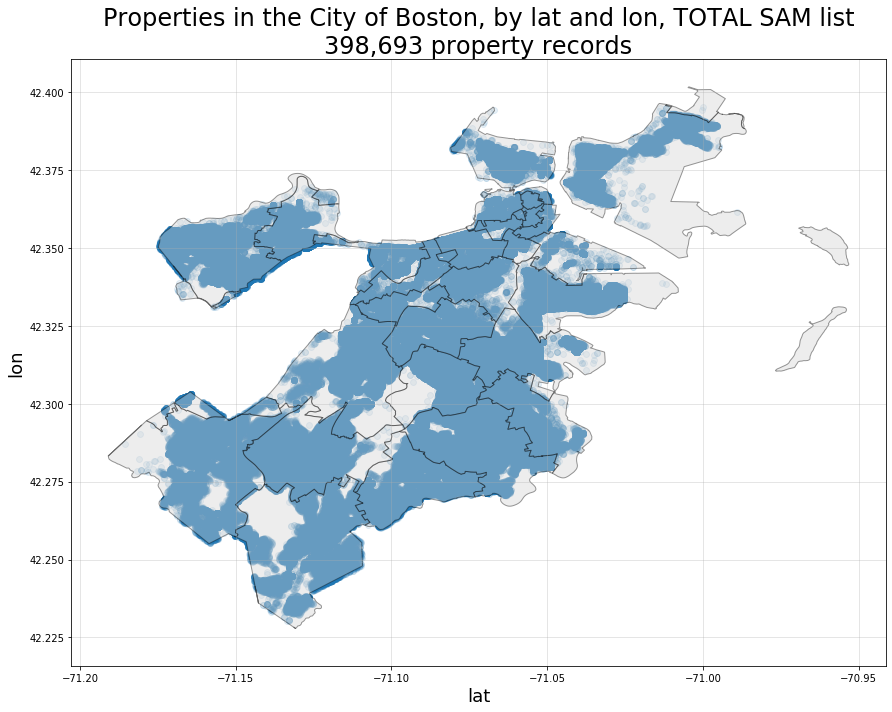

CPU times: user 3.83 s, sys: 0 ns, total: 3.83 s
Wall time: 3.83 s


In [38]:
%%time

fig, ax = plt.subplots(figsize=(16,10))
plt.title(
    'Properties in the City of Boston, by lat and lon, TOTAL SAM list\n'\
    '{0:,} property records'.format(len(df_sam)),
    fontsize=24
)
plt.scatter(df_sam['X'], df_sam['Y'], alpha=0.1)
df_zipshape.plot(ax=ax, color='lightgray', edgecolor='k', alpha=0.4)

plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show();

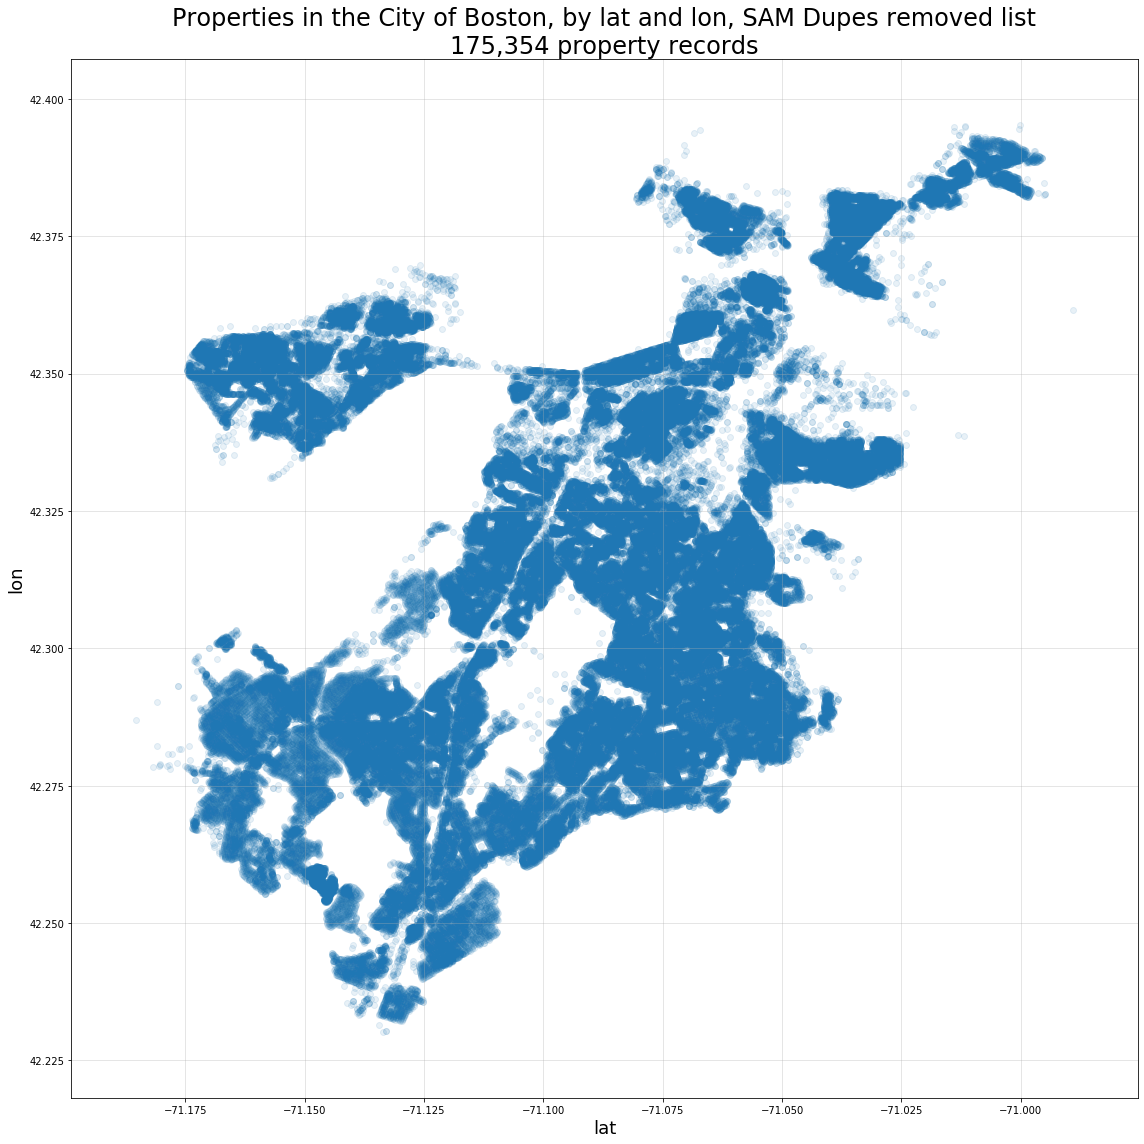

CPU times: user 1.19 s, sys: 3.91 ms, total: 1.19 s
Wall time: 1.19 s


In [233]:
%%time

fig, ax = plt.subplots(figsize=(16,16))
plt.title(
    'Properties in the City of Boston, by lat and lon, SAM Dupes removed list\n'\
    '{0:,} property records'.format(len(df_locs)),
    fontsize=24
)
plt.scatter(df_locs['X'], df_locs['Y'], alpha=0.1)
plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show();

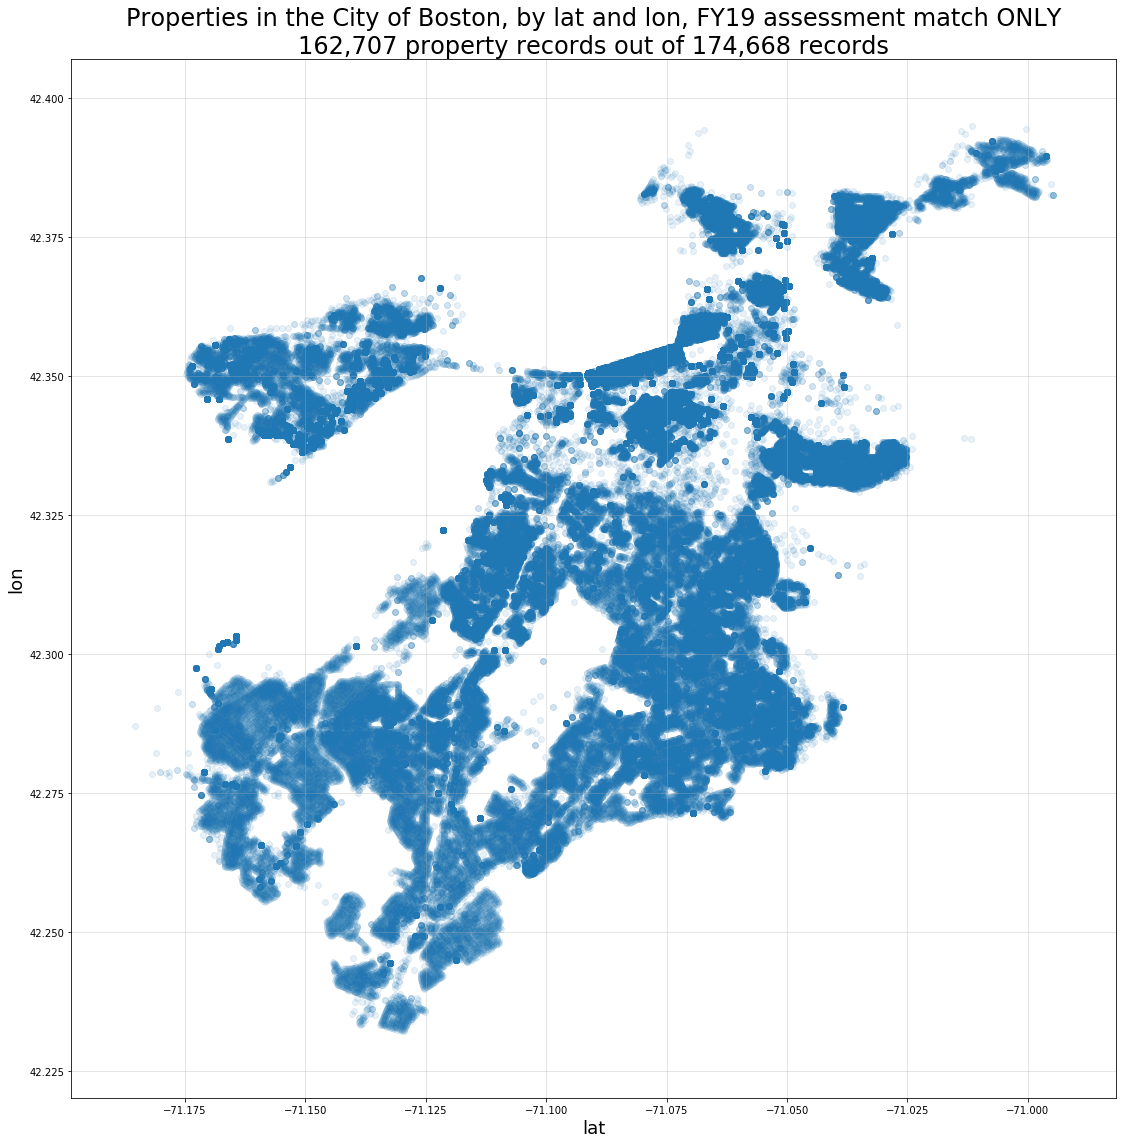

CPU times: user 1.13 s, sys: 7.94 ms, total: 1.14 s
Wall time: 1.14 s


In [237]:
%%time

fig, ax = plt.subplots(figsize=(16,16))
plt.title(
    'Properties in the City of Boston, by lat and lon, FY19 assessment match ONLY\n'\
    '{0:,} property records out of {1:,} records'.format(len(df_merge), len(df_prop)),
    fontsize=24
)
plt.scatter(df_merge['X'], df_merge['Y'], alpha=0.1)
plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show();

In [238]:
print(df_prop['AV_TOTAL'].astype(float).describe()['mean'])

2518831.209299929


In [239]:
print(df_merge['AV_TOTAL'].astype(float).describe()['mean'])

2598004.208356125


In [240]:
print(df_merge_nomatch['AV_TOTAL'].astype(float).describe()['mean'])

1441830.8617172476


In [244]:
print(df_merge_nomatch.loc[df_merge_nomatch['ZIPCODE']=='02132']['AV_TOTAL'].astype(float).describe()['mean'])

162418.71932114882


ZIP    LOCALE
02132  W Roxbury
02124  Dorchester
02136  Hyde Park
02119  Roxbury

In [241]:
df_merge_nomatch['ZIPCODE'].value_counts()

02132    1532
02124    1032
02136     919
02119     852
02130     763
02125     673
02126     660
02131     606
02121     604
02128     587
02122     512
02129     426
02210     416
02135     387
02127     358
02115     321
02118     269
02120     264
02134     177
02215     125
02111     123
02116     105
02114      69
02110      53
02109      43
02113      39
02467      36
02108       6
02201       2
02112       1
02090       1
Name: ZIPCODE, dtype: int64

In [247]:
df_merge_nomatch.loc[df_merge_nomatch['ZIPCODE']=='02132'].iloc[:, :20]

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,OWN_OCC,OWNER,MAIL_ADDRESSEE,MAIL_ADDRESS,MAIL CS,MAIL_ZIPCODE,AV_LAND,AV_BLDG,AV_TOTAL,GROSS_TAX
11216,2000101000,NaN,2000101000,,COHASSET,ST,NaN,02132,986,E,N,ACTION FOR BOSTON COMMUNITY,ACTION FOR BOSTON COMM DEV C,178 TREMONT ST,BOSTON MA,2111,153900,0,153900,0
11258,2000676000,NaN,2000676000,,W ROXBURY,PW,NaN,02132,985,E,N,COMMWLTH OF MASS,,WEST ROXBURY PKWY,ROSLINDALE MA,2131,17976200,0,17976200,0
11339,2001573001,NaN,2001573001,,ANAWAN,AV,NaN,02132,132,RL,N,MICHAELS STEPHEN G,,4 ANAWAN AVE,WEST ROXBURY MA,2132,42300,0,42300,44584
11341,2001594000,NaN,2001594000,,ANAWAN,AV,NaN,02132,132,RL,N,MATTHEWS JOSEPH P,,23 ANAWAN AVE,WEST ROXBURY MA,2132,800,0,800,843
11343,2001603000,NaN,2001603000,,BEECH,ST,NaN,02132,337,CL,N,KYL 400 BELGRADE LLC,,195 LEE ST,BROOKLINE MA,2445,99400,0,99400,248500
11344,2001605000,NaN,2001605000,399,BELGRADE,AV,NaN,02132,132,RL,N,BANKHEAD RICHARD TS,,399 BELGRADE AVE,WEST ROXBURY MA,2132,34200,0,34200,36047
11345,2001608000,NaN,2001608000,,BELGRADE,AV,NaN,02132,132,RL,N,KENNEALLY JOSEPH A,,415 BELGRADE AVE,WEST ROXBURY MA,2132,4400,0,4400,4638
11346,2001613500,NaN,2001613500,,BELGRADE,AV,NaN,02132,986,E,N,MASS BAY TRANS AUTH,,BELGRADE AV,WEST ROXBURY MA,2132,568300,0,568300,0
11347,2001642000,NaN,2001642000,,STRATFORD,ST,NaN,02132,106,RL,N,SETTANA DANIEL R TS,,10 STRATFORD,WEST ROXBURY MA,2132,89400,0,89400,94228
11348,2001655000,NaN,2001655000,,STRATFORD,ST,NaN,02132,132,RL,N,WALSH DANIEL M TS,,29 STRATFORD ST,WEST ROXBURY MA,2132,85200,0,85200,89801


In [252]:
df_merge_nomatch.loc[
    (df_merge_nomatch['ZIPCODE']=='02132') & (df_merge_nomatch['ST_NUM'].str.strip() == '')
].iloc[:, :20]

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,OWN_OCC,OWNER,MAIL_ADDRESSEE,MAIL_ADDRESS,MAIL CS,MAIL_ZIPCODE,AV_LAND,AV_BLDG,AV_TOTAL,GROSS_TAX
11216,2000101000,NaN,2000101000,,COHASSET,ST,NaN,02132,986,E,N,ACTION FOR BOSTON COMMUNITY,ACTION FOR BOSTON COMM DEV C,178 TREMONT ST,BOSTON MA,2111,153900,0,153900,0
11258,2000676000,NaN,2000676000,,W ROXBURY,PW,NaN,02132,985,E,N,COMMWLTH OF MASS,,WEST ROXBURY PKWY,ROSLINDALE MA,2131,17976200,0,17976200,0
11339,2001573001,NaN,2001573001,,ANAWAN,AV,NaN,02132,132,RL,N,MICHAELS STEPHEN G,,4 ANAWAN AVE,WEST ROXBURY MA,2132,42300,0,42300,44584
11341,2001594000,NaN,2001594000,,ANAWAN,AV,NaN,02132,132,RL,N,MATTHEWS JOSEPH P,,23 ANAWAN AVE,WEST ROXBURY MA,2132,800,0,800,843
11343,2001603000,NaN,2001603000,,BEECH,ST,NaN,02132,337,CL,N,KYL 400 BELGRADE LLC,,195 LEE ST,BROOKLINE MA,2445,99400,0,99400,248500
11345,2001608000,NaN,2001608000,,BELGRADE,AV,NaN,02132,132,RL,N,KENNEALLY JOSEPH A,,415 BELGRADE AVE,WEST ROXBURY MA,2132,4400,0,4400,4638
11346,2001613500,NaN,2001613500,,BELGRADE,AV,NaN,02132,986,E,N,MASS BAY TRANS AUTH,,BELGRADE AV,WEST ROXBURY MA,2132,568300,0,568300,0
11347,2001642000,NaN,2001642000,,STRATFORD,ST,NaN,02132,106,RL,N,SETTANA DANIEL R TS,,10 STRATFORD,WEST ROXBURY MA,2132,89400,0,89400,94228
11348,2001655000,NaN,2001655000,,STRATFORD,ST,NaN,02132,132,RL,N,WALSH DANIEL M TS,,29 STRATFORD ST,WEST ROXBURY MA,2132,85200,0,85200,89801
11349,2001682000,NaN,2001682000,,PARK,ST,NaN,02132,130,RL,N,GUARINO JOSE M ETAL,,164 PARK,WEST ROXBURY MA,2132,264100,0,264100,278361


In [251]:
df_merge_nomatch.loc[
    (df_merge_nomatch['ZIPCODE']=='02132') & (df_merge_nomatch['ST_NUM'].str.strip() != '')
].iloc[:, :20]

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,OWN_OCC,OWNER,MAIL_ADDRESSEE,MAIL_ADDRESS,MAIL CS,MAIL_ZIPCODE,AV_LAND,AV_BLDG,AV_TOTAL,GROSS_TAX
11344,2001605000,NaN,2001605000,399,BELGRADE,AV,NaN,02132,132,RL,N,BANKHEAD RICHARD TS,,399 BELGRADE AVE,WEST ROXBURY MA,2132,34200,0,34200,36047
11356,2001868010,NaN,2001868010,763,W ROXBURY,PW,NaN,02132,101,R1,Y,GARNER CAROL V,,763 WEST ROXBURY PKWY,WEST ROXBURY MA,2132,234100,384700,618800,652215
11357,2001870010,NaN,2001870010,767,W ROXBURY,PW,NaN,02132,906,E,N,ROMAN CATHOLIC ARCHBISHOP,C/O RCAB/REAL ESTATE,2121 COMMONWEALTH AV,BRIGHTON MA,2135,225600,566600,792200,0
11370,2002168004,NaN,2002168004,60,WREN,ST,NaN,02132,132,RL,N,SISTERS OF CHARITY ST MARY,C/O SR RITA FARLEY,58 WREN ST,WEST ROXBURY MA,2132,40500,0,40500,42687
11431,2002843010,NaN,2002843010,32,SPARROW,ST,NaN,02132,101,R1,Y,YANG CHUNHUA,,32 SPARROW ST,WEST ROXBURY MA,2132,158700,614000,772700,814426
11494,2003023000,NaN,2003023000,5061,WASHINGTON,ST,NaN,02132,132,RL,N,TRUSTEES OF ROXBURY LATIN,C/O TRUSTEES OF ROXBURY LATI,101 ST THERESA AV,WEST ROXBURY MA,2132,41200,0,41200,43425
11532,2003106000,NaN,2003106000,70,GROVE,ST,NaN,02132,390,CL,N,S M LORUSSO & SONS INC,,331 WEST ST,WALPOLE MA,2081,169800,0,169800,424500
11535,2003109000,NaN,2003109000,62,GROVE,ST,NaN,02132,132,RL,N,S M LORUSSO & SONS INC,,331 WEST ST,WALPOLE MA,2081,28700,0,28700,30250
11559,2003154000,NaN,2003154000,27,WEDGEMERE,RD,NaN,02132,101,R1,Y,FINNERTY SHEILA A,,27 WEDGEMERE RD,WEST ROXBURY MA,2132,123500,270900,394400,415698
11567,2003181010,NaN,2003181010,43,WOODBRIER,RD,NaN,02132,101,R1,Y,KIESSLING KURT F,C/O KURT & SHEILA KIESSLING,43 WOODBRIER RD,WEST ROXBURY MA,2132,165000,440900,605900,638619
